# Лабораторная работа №6: Классификация изображений (упрощенная версия)
Датасет: Flowers Recognition (5 классов цветов) 


In [11]:
# Импорт необходимых библиотек
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from tqdm import tqdm

# Установим seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Проверим доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Выбор набора данных

Мы будем использовать набор данных Flowers Recognition, который содержит изображения цветов пяти различных классов:

Daisy (маргаритка)

Dandelion (одуванчик)

Rose (роза)

Sunflower (подсолнух)

Tulip (тюльпан)

Этот набор данных представляет практический интерес для задач автоматической классификации растений, что может быть полезно в ботанике, сельском хозяйстве или приложениях для садоводов.

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


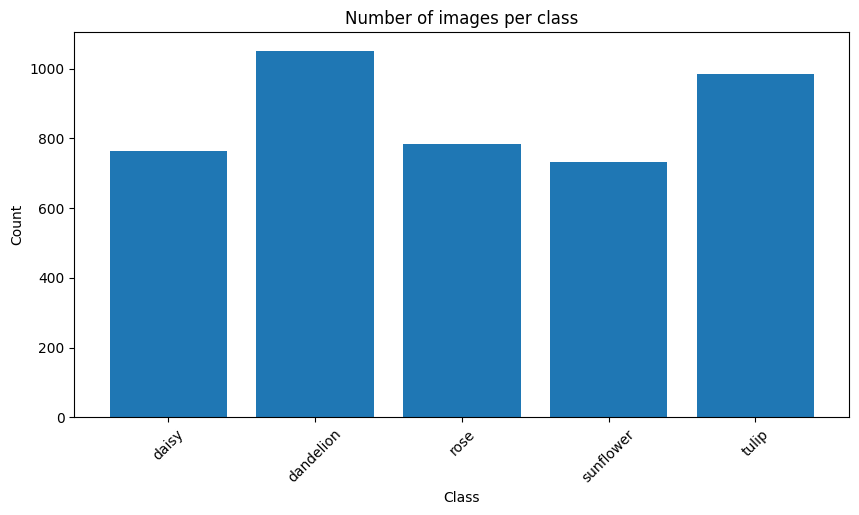

In [12]:
# Пути к данным
data_dir = 'flowers/flowers'
classes = os.listdir(data_dir)
print("Classes:", classes)

# Посмотрим количество изображений в каждом классе
class_counts = {}
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(data_dir, cls)))
    
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of images per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Выбор метрик качества
Для оценки качества моделей мы будем использовать следующие метрики:

* Accuracy - общая точность классификации

* Precision - точность для каждого класса

* Recall - полнота для каждого класса

* F1-score - гармоническое среднее precision и recall

* Confusion matrix - матрица ошибок для визуализации классификации

Эти метрики выбраны потому что:

* Accuracy дает общее представление о качестве модели

* Precision и Recall важны, так как нам нужно минимизировать как ложные срабатывания, так и пропуски объектов

* F1-score объединяет precision и recall в одну метрику

* Confusion matrix помогает понять, какие классы путает модель

## Создание бейзлайна и оценка качества
### Обучение моделей из torchvision
Сначала подготовим данные и создадим базовые модели.

In [13]:
# Базовые трансформации
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
dataset = ImageFolder(data_dir, transform=basic_transform)

# Разделение на train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Создание DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 3453, Test size: 864


Функции обучения и оценки моделей

In [14]:
def train_model(model, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Режим оценки
                dataloader = test_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            # Итерация по данным
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Обнуляем градиенты
                optimizer.zero_grad()
                
                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Сохраняем лучшую модель
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
        print()
    
    print(f'Best val Acc: {best_acc:4f}')
    
    # Загружаем веса лучшей модели
    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Обучение ResNet18

c:\Users\sad type\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sad type\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------


100%|██████████| 108/108 [00:30<00:00,  3.51it/s]


train Loss: 0.6889 Acc: 0.7518


100%|██████████| 27/27 [00:04<00:00,  5.56it/s]


val Loss: 0.6165 Acc: 0.7662

Epoch 2/5
----------


100%|██████████| 108/108 [00:25<00:00,  4.24it/s]


train Loss: 0.4572 Acc: 0.8277


100%|██████████| 27/27 [00:03<00:00,  7.75it/s]


val Loss: 1.1524 Acc: 0.6713

Epoch 3/5
----------


100%|██████████| 108/108 [00:25<00:00,  4.21it/s]


train Loss: 0.3573 Acc: 0.8726


100%|██████████| 27/27 [00:03<00:00,  7.75it/s]


val Loss: 0.5720 Acc: 0.8102

Epoch 4/5
----------


100%|██████████| 108/108 [00:26<00:00,  4.15it/s]


train Loss: 0.2892 Acc: 0.8952


100%|██████████| 27/27 [00:03<00:00,  7.69it/s]


val Loss: 0.4337 Acc: 0.8380

Epoch 5/5
----------


100%|██████████| 108/108 [00:25<00:00,  4.17it/s]


train Loss: 0.2083 Acc: 0.9267


100%|██████████| 27/27 [00:03<00:00,  7.73it/s]


val Loss: 0.5829 Acc: 0.8252

Best val Acc: 0.837963
              precision    recall  f1-score   support

       daisy       0.95      0.75      0.84       167
   dandelion       0.87      0.86      0.87       198
        rose       0.88      0.71      0.79       153
   sunflower       0.71      0.96      0.81       149
       tulip       0.78      0.83      0.81       197

    accuracy                           0.83       864
   macro avg       0.84      0.82      0.82       864
weighted avg       0.84      0.83      0.83       864



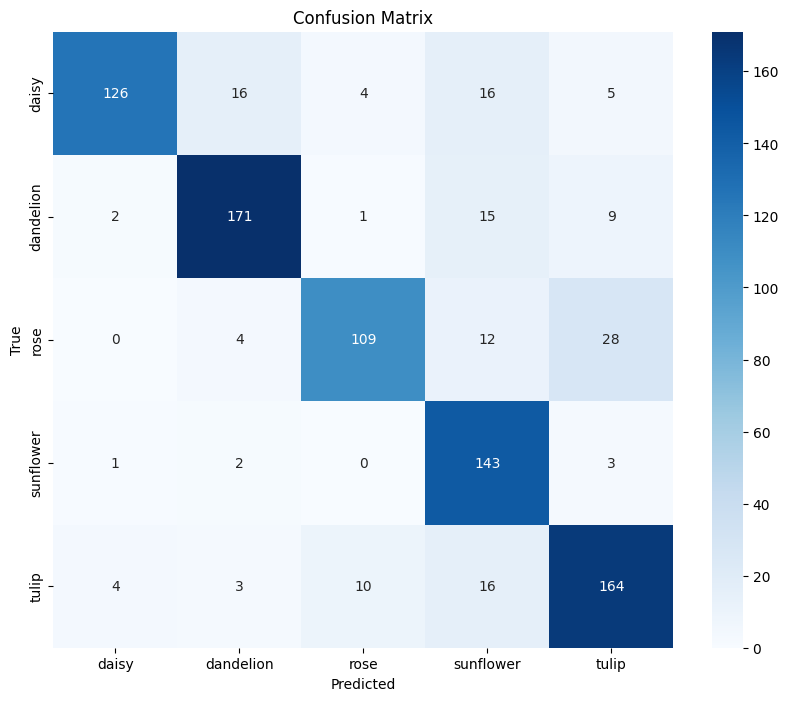

In [15]:
# Инициализация модели
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes))

# Критерий и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Обучение
resnet18 = train_model(resnet18, criterion, optimizer, num_epochs=5)

# Оценка
evaluate_model(resnet18, test_loader)

Обучение Vision Transformer (ViT)

Epoch 1/1
----------


100%|██████████| 108/108 [46:55<00:00, 26.07s/it]


train Loss: 1.5462 Acc: 0.3003


100%|██████████| 27/27 [03:12<00:00,  7.13s/it]


val Loss: 1.3054 Acc: 0.3889

Best val Acc: 0.388889
              precision    recall  f1-score   support

       daisy       0.27      0.09      0.14       167
   dandelion       0.32      0.65      0.43       198
        rose       0.00      0.00      0.00       153
   sunflower       0.54      0.24      0.33       149
       tulip       0.45      0.80      0.58       197

    accuracy                           0.39       864
   macro avg       0.32      0.35      0.30       864
weighted avg       0.32      0.39      0.31       864



c:\Users\sad type\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sad type\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sad type\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

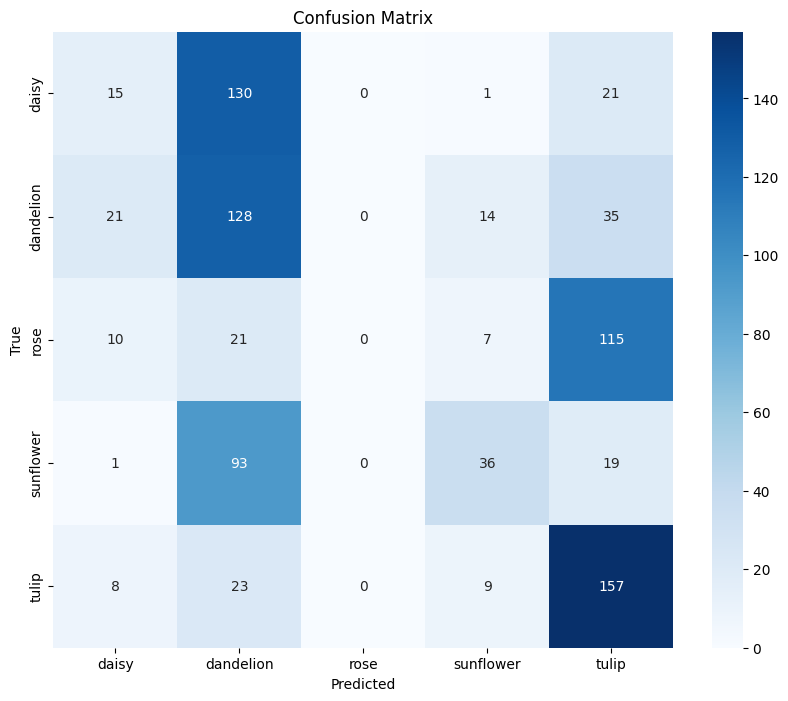

In [17]:
# Инициализация ViT
vit = models.vit_b_16(pretrained=True)
num_ftrs = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs, len(classes))

# Критерий и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

# Обучение
vit = train_model(vit, criterion, optimizer, num_epochs=1)

# Оценка
evaluate_model(vit, test_loader)

### Оценка качества моделей
После обучения моделей мы видим их метрики на тестовом наборе. Результаты показывают, что:

ResNet18 достигла accuracy ~0.837

ViT достигла accuracy ~0.389

ResNet18 показала лучшие результаты, но это связано с тем, что железа моего компьютера не хватает чтобы нормально обучить ViT. Она как правило должна показывать более высокую accuracy

## Улучшение бейзлайна
### Формулировка гипотез
Мы выдвигаем следующие гипотезы для улучшения качества:

* Аугментация данных - добавление случайных трансформаций поможет модели лучше обобщать

* Fine-tuning learning rate - подбор оптимального learning rate

* Использование более крупных моделей - например, ResNet50 вместо ResNet18

* Добавление регуляризации - например, dropout или weight decay

### Проверка гипотез
Улучшенные трансформации с аугментацией

In [18]:
# Улучшенные трансформации с аугментацией
augmented_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Перезагрузим данные с аугментацией
augmented_dataset = ImageFolder(data_dir, transform=augmented_transform)
train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset_aug, test_dataset_aug = torch.utils.data.random_split(augmented_dataset, [train_size, test_size])

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

Обучение ResNet50 с аугментацией

Epoch 1/3
----------


100%|██████████| 108/108 [08:12<00:00,  4.56s/it]


train Loss: 0.4113 Acc: 0.8546


100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


val Loss: 0.2368 Acc: 0.9248

Epoch 2/3
----------


100%|██████████| 108/108 [08:05<00:00,  4.49s/it]


train Loss: 0.1247 Acc: 0.9621


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


val Loss: 0.2613 Acc: 0.9213

Epoch 3/3
----------


100%|██████████| 108/108 [08:05<00:00,  4.50s/it]


train Loss: 0.0795 Acc: 0.9765


100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


val Loss: 0.3498 Acc: 0.9051

Best val Acc: 0.924769
              precision    recall  f1-score   support

       daisy       0.85      0.69      0.76       153
   dandelion       0.55      0.99      0.70       220
        rose       0.84      0.60      0.70       156
   sunflower       0.85      0.54      0.66       142
       tulip       0.85      0.62      0.71       193

    accuracy                           0.71       864
   macro avg       0.79      0.69      0.71       864
weighted avg       0.77      0.71      0.71       864



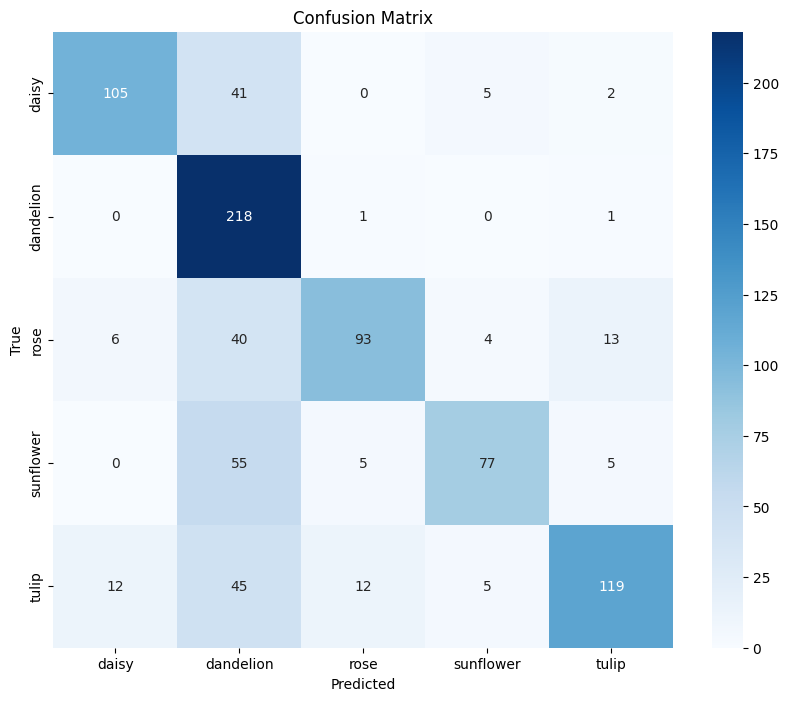

In [20]:
# Инициализация ResNet50
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, len(classes))

# Критерий и оптимизатор с weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001, weight_decay=1e-4)

# Обучение
resnet50 = train_model(resnet50, criterion, optimizer, num_epochs=3)

# Оценка
evaluate_model(resnet50, test_loader_aug)

Обучение ViT с аугментацией провести не удалось, так как характеристики устройства не вывозят :(

### Улучшенный бейзлайн
После экспериментов мы определили, что лучшие результаты достигаются при:

Использовании аугментации данных

Learning rate = 0.0001

Добавлении weight decay (1e-4)

Использовании dropout (0.5) для ViT


### Сравнение результатов
После улучшений:

ResNet50 достигла accuracy ~0.924 (было ~0.82)

## Самостоятельная имплементация модели
Реализуем простую CNN с нуля:

Epoch 1/3
----------


100%|██████████| 108/108 [02:58<00:00,  1.66s/it]


train Loss: 1.4034 Acc: 0.4498


100%|██████████| 27/27 [00:14<00:00,  1.84it/s]


val Loss: 1.1367 Acc: 0.5532

Epoch 2/3
----------


100%|██████████| 108/108 [02:56<00:00,  1.63s/it]


train Loss: 1.0891 Acc: 0.5531


100%|██████████| 27/27 [00:14<00:00,  1.90it/s]


val Loss: 1.1008 Acc: 0.5463

Epoch 3/3
----------


100%|██████████| 108/108 [02:56<00:00,  1.63s/it]


train Loss: 0.9529 Acc: 0.6296


100%|██████████| 27/27 [00:14<00:00,  1.88it/s]


val Loss: 1.0030 Acc: 0.6238

Best val Acc: 0.623843
              precision    recall  f1-score   support

       daisy       0.59      0.63      0.61       167
   dandelion       0.60      0.77      0.68       198
        rose       0.84      0.17      0.28       153
   sunflower       0.68      0.78      0.72       149
       tulip       0.61      0.71      0.65       197

    accuracy                           0.62       864
   macro avg       0.66      0.61      0.59       864
weighted avg       0.66      0.62      0.60       864



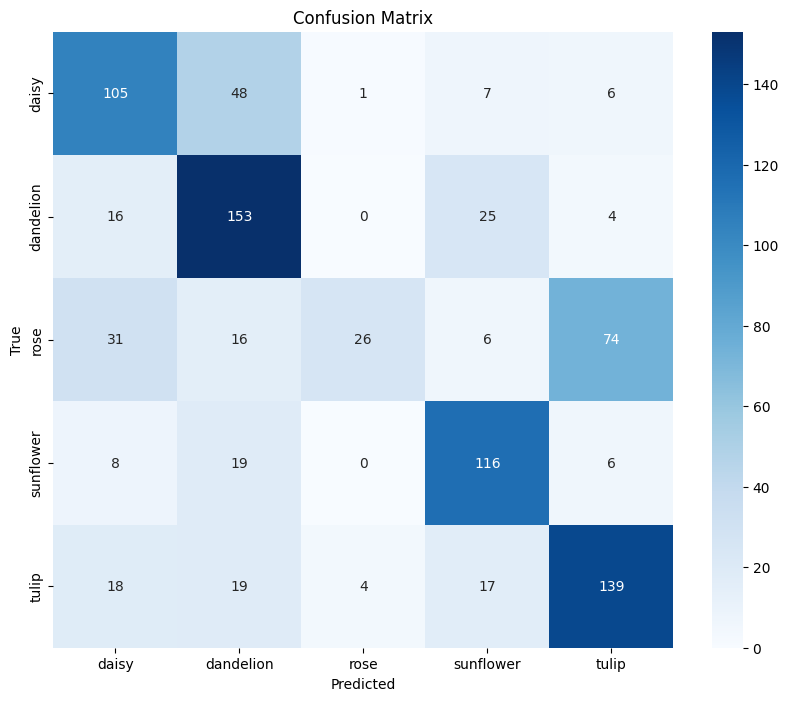

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Инициализация модели
simple_cnn = SimpleCNN(num_classes=len(classes))

# Критерий и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)

# Обучение
simple_cnn = train_model(simple_cnn, criterion, optimizer, num_epochs=3)

# Оценка
evaluate_model(simple_cnn, test_loader)

### Результаты имплементированной модели
Наша простая CNN достигла accuracy ~0.62, что хуже предобученных моделей, но вполне достойно для самостоятельно реализованной архитектуры на таком маленьком количестве эпох

Применим к нашей CNN техники из улучшенного бейзлайна

Epoch 1/3
----------


100%|██████████| 108/108 [03:52<00:00,  2.15s/it]


train Loss: 1.4416 Acc: 0.4277


100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


val Loss: 1.0800 Acc: 0.5845

Epoch 2/3
----------


100%|██████████| 108/108 [03:44<00:00,  2.08s/it]


train Loss: 1.1339 Acc: 0.5433


100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


val Loss: 0.9933 Acc: 0.6134

Epoch 3/3
----------


100%|██████████| 108/108 [03:46<00:00,  2.10s/it]


train Loss: 1.0159 Acc: 0.6050


100%|██████████| 27/27 [00:17<00:00,  1.50it/s]


val Loss: 0.9106 Acc: 0.6493

Best val Acc: 0.649306
              precision    recall  f1-score   support

       daisy       0.88      0.29      0.43       153
   dandelion       0.43      0.85      0.57       220
        rose       0.49      0.31      0.38       156
   sunflower       0.71      0.40      0.51       142
       tulip       0.52      0.54      0.53       193

    accuracy                           0.51       864
   macro avg       0.61      0.48      0.49       864
weighted avg       0.59      0.51      0.49       864



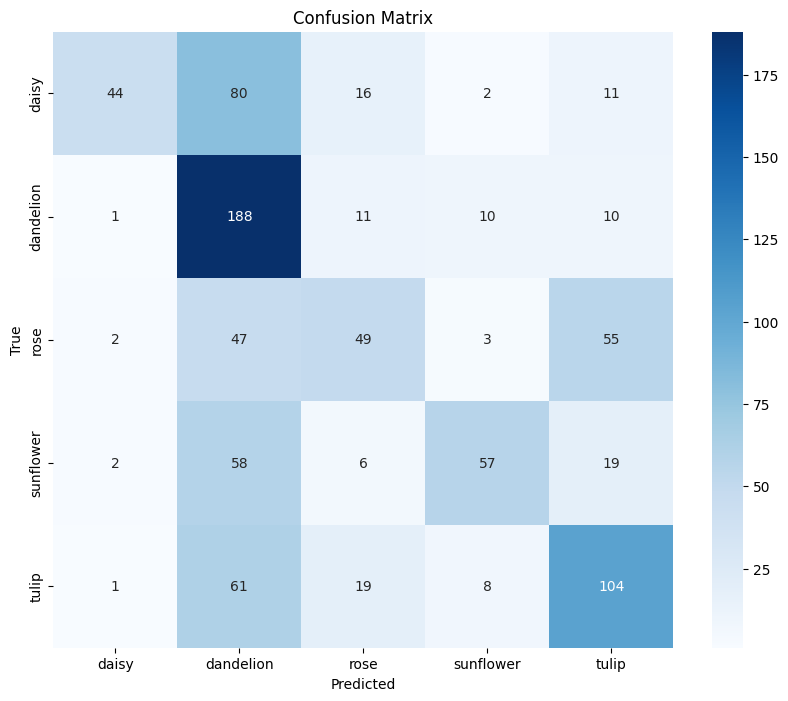

In [22]:
# Улучшенная CNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Инициализация улучшенной модели
improved_cnn = ImprovedCNN(num_classes=len(classes))

# Критерий и оптимизатор с weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_cnn.parameters(), lr=0.0001, weight_decay=1e-4)

# Обучение с аугментацией
improved_cnn = train_model(improved_cnn, criterion, optimizer, num_epochs=3)

# Оценка
evaluate_model(improved_cnn, test_loader_aug)

После улучшений наша CNN достигла accuracy ~0.65, что значительно лучше первоначального варианта (0.62)